# TQuant Lab 線上工作坊 - 巴菲特選股策略範例_回測參數設定對績效的影響

本策略目的:

- 仿照巴菲特的選股策略，運用TejToolAPI、TQuant Lab和tejapi等工具進行實踐，篩選出在2023年1月初符合條件的股票清單，並分析買入持有這些股票的績效。

本策略分成以下兩部分：
- 運用 TejToolAPI 抓取巴菲特選股策略所需之財務面日資料，將資料進行清洗與篩選後，找出符合選股策略的標的。
- 運用 TQuant Lab 將標的進行買進持有一年 (2023-01-01 至 2023-12-31)，觀察其風險與報酬表現。

本範例整理的六大選股條件如下：

1. 最近年度股東權益報酬率 ＞ 產業平均值
2. 2 年平均股東權益報酬率 ＞ 15 %
3. 最近年度毛利率 ＞ 產業平均值
4. 自由現金流量年增率 > 0
5. 本益比 < 產業本益比中位數
6. 負債比率 < 30%

## 設定基本套件與環境

``` python
os.environ['TEJAPI_KEY'] = tej_key    ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base  ==> 導航至 tej api 網域。
```

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tejapi

# tej_key

tej_key = 'your key'
api_base = "https://api.tej.com.tw"

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 使用 `get_universe()` 函式取得股票池
`get_universe()` 函數可以幫助我們抓取特定的股票池（市場、板塊、證券種類、產業）。  
另外，因為 ROE 可以藉由舉債來提升，所以我們排除金融產業這類高槓桿的產業。

p.s. 關於 `get_universe()` 的說明，可參考 TQuant Lab github：[get_universe 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/get_universe%E8%AA%AA%E6%98%8E.ipynb)

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2023-01-03', 
                    end = '2023-01-03',  # 選取 2023 年年初已上市的股票
                    mkt_bd_e = 'TSE',  # 已上市之股票
                    stktp_e = 'Common Stock',  # 普通股 
                    main_ind_e = 'General Industry') # general industry 篩掉金融產業
pool

Currently used TEJ API key call quota 779/100000 (0.78%)
Currently used TEJ API key data quota 95968854/10000000 (959.69%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 

In [3]:
len(pool)

861

## 利用 TejToolAPI、tejapi 抓取所需的財務資料
根據上述選股條件，我們需要的財務科目有以下 7 項：
1. 主產業別_中文
2. 常續ROE
3. 營業毛利率
4. 營運產生現金流量
5. 投資產生現金流量
6. 負債比率
7. 本益比-tej


註： 
- TejToolAPI 的詳細使用方法可參考 TQuant Lab github：[TejToolAPI 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)
- TejToolAPI 提供之資料集可參考 TQuant Lab 官網：[TQuant Lab 資料集](https://tquant.tejwin.com/%e8%b3%87%e6%96%99%e9%9b%86/)

In [4]:
import TejToolAPI

start_time = pd.Timestamp('2021-01-04')
end_time = pd.Timestamp('2023-01-03')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE', '營業毛利率', '營運產生現金流量', '投資產生現金流量', '負債比率', 'per_tej'],
                                   transfer_to_chinese = True)

data['自由現金流量'] = data['營運產生現金流量_A'] + data['投資產生現金流量_A']  # 計算自由現金流量 = 營運產生現金流量 + (-)投資產生現金流量

data.drop(columns = ['營運產生現金流量_A', '投資產生現金流量_A'], inplace = True)  # 移除欄位

data

Currently used TEJ API key call quota 870/100000 (0.87%)
Currently used TEJ API key data quota 97458347/10000000 (974.58%)


,股票代碼,日期,主產業別_中文,本益比_TEJ,負債比率_A,營業毛利率_A,常續ROE_A,自由現金流量
0,1101,2021-01-04,M1100 水泥工業,9.6603,45.29,33.09,9.26,-6479665.0
1,1101,2021-01-05,M1100 水泥工業,9.6379,45.29,33.09,9.26,-6479665.0
2,1101,2021-01-06,M1100 水泥工業,9.6044,45.29,33.09,9.26,-6479665.0
3,1101,2021-01-07,M1100 水泥工業,9.5820,45.29,33.09,9.26,-6479665.0
4,1101,2021-01-08,M1100 水泥工業,9.6284,45.29,33.09,9.26,-6479665.0
...,...,...,...,...,...,...,...,...
414332,9958,2022-12-27,M2000 鋼鐵工業,31.4780,67.71,10.79,4.35,-686003.0
414333,9958,2022-12-28,M2000 鋼鐵工業,32.8731,67.71,10.79,4.35,-686003.0
414334,9958,2022-12-29,M2000 鋼鐵工業,32.4796,67.71,10.79,4.35,-686003.0
414335,9958,2022-12-30,M2000 鋼鐵工業,31.6926,67.71,10.79,4.35,-686003.0


* 由於公司在剛上市時都會有IPO行情，在此期間的股價波動較大，為避免市場的不理性影響策略績效，故只選取在2023/01/03時已上市超過一年的公司
* 使用tejapi抓取公司的屬性資料，取得每家公司的最近一次上市日

In [5]:
latest_list_date = tejapi.fastget('TWN/APISTOCK', coid = pool, paginate = True, chinese_column_name = True, opts = {'columns':['coid', 'mdate', 'list_date']})

latest_list_date

,公司簡稱,目前狀態,最近一次上市日
0,1101,2024-01-01,1962-02-09
1,1102,2024-01-01,1962-06-18
2,1103,2024-01-01,1969-11-27
3,1104,2024-01-01,1971-02-02
4,1108,2024-01-01,1990-06-06
...,...,...,...
856,9944,2024-01-01,2001-01-16
857,9945,2024-01-01,1992-04-30
858,9946,2024-01-01,2002-01-02
859,9955,2024-01-01,2002-12-02


* 與get_history_data的日財務資料合併
* 計算每天與最近一次上市日的差異天數

In [6]:
data1 = data.merge(latest_list_date, left_on=['股票代碼'], right_on=['公司簡稱'], how='left')

data1.drop(columns=['公司簡稱', '目前狀態'], inplace=True)

data1['已上市天數'] = (data1['日期'] - data1['最近一次上市日']).dt.days

* 找出在2023/01/03時，上市天數未滿365天的公司

In [7]:
new_onboard_company = data1.query("日期 == 日期.max() & 已上市天數 < 365")['股票代碼'].unique()

new_onboard_company

array(['3715'], dtype=object)

In [8]:
data1 = data1[~data1['股票代碼'].isin(new_onboard_company)].reset_index(drop=True)

## 選股條件 1：最近年度股東權益報酬率＞產業平均值

In [9]:
# 取出最近年度(2022-12-30)的資料
data_last_1Y = data1[data1['日期'] == '2022-12-30'].reset_index(drop = True)  

# 取出股票基本資料與 ROE 資料方便觀察
ROE_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '常續ROE_A']]

ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A
0,1101,2022-12-30,M1100 水泥工業,-0.07
1,1102,2022-12-30,M1100 水泥工業,5.60
2,1103,2022-12-30,M1100 水泥工業,-1.32
3,1104,2022-12-30,M1100 水泥工業,5.10
4,1108,2022-12-30,M1100 水泥工業,6.30
...,...,...,...,...
855,9944,2022-12-30,M9900 其他,1.94
856,9945,2022-12-30,M9900 其他,22.26
857,9946,2022-12-30,M2500 建材營造,1.51
858,9955,2022-12-30,M9900 其他,-5.44


In [10]:
# 計算'產業平均ROE' 欄位，依照不同產業分類，計算出產業平均 ROE
ROE_1Y_data['產業平均ROE'] = ROE_1Y_data.groupby('主產業別_中文')['常續ROE_A'].transform('mean')
 
ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A,產業平均ROE
0,1101,2022-12-30,M1100 水泥工業,-0.07,2.777143
1,1102,2022-12-30,M1100 水泥工業,5.60,2.777143
2,1103,2022-12-30,M1100 水泥工業,-1.32,2.777143
3,1104,2022-12-30,M1100 水泥工業,5.10,2.777143
4,1108,2022-12-30,M1100 水泥工業,6.30,2.777143
...,...,...,...,...,...
855,9944,2022-12-30,M9900 其他,1.94,8.972090
856,9945,2022-12-30,M9900 其他,22.26,8.972090
857,9946,2022-12-30,M2500 建材營造,1.51,6.178400
858,9955,2022-12-30,M9900 其他,-5.44,8.972090


In [11]:
condition1 = set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['股票代碼'])  # 篩選符合選股條件的公司
condition1

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1215',
 '1216',
 '1218',
 '1219',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1301',
 '1303',
 '1307',
 '1308',
 '1309',
 '1315',
 '1319',
 '1323',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1413',
 '1435',
 '1436',
 '1438',
 '1439',
 '1440',
 '1443',
 '1444',
 '1451',
 '1452',
 '1464',
 '1465',
 '1468',
 '1470',
 '1473',
 '1475',
 '1476',
 '1477',
 '1503',
 '1513',
 '1514',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 '1526',
 '1527',
 '1530',
 '1535',
 '1536',
 '1537',
 '1539',
 '1540',
 '1541',
 '1558',
 '1560',
 '1568',
 '1583',
 '1587',
 '1597',
 '1604',
 '1605',
 '1615',
 '1707',
 '1708',
 '1709',
 '1712',
 '1713',
 '1717',
 '1720',
 '1723',
 '1730',
 '1733',
 '1752',
 '1760',
 '1762',
 '1773',
 '1783',
 '1795',
 '1817',
 '1904',
 '1905',
 '2006',
 '2012',
 '2013',
 '2015',
 '2020',
 '2025',
 '2027',
 '2028',
 '2030',
 '2034',
 '2049',
 '2059',
 '2062',
 '2103',
 '2105',
 '2106',
 '2108',
 '2109',
 '2114',
 

In [12]:
len(condition1)

417

## 選股條件 2：2 年平均股東權益報酬率＞15%

In [13]:
# 取出近兩年(2022-12-30, 2021-12-30)的資料
data_last_2Y = data1[data1['日期'].isin(['2022-12-30', '2021-12-30'])].reset_index(drop = True)

# 計算公司兩年平均的 ROE
ROE_2Y_ave = data_last_2Y.groupby('股票代碼')['常續ROE_A'].mean()

# 從 Series 轉成 Dataframe，並重新命名欄位
ROE_2Y_ave = pd.DataFrame(ROE_2Y_ave).rename(columns = {'常續ROE_A': '2年平均ROE'})

ROE_2Y_ave

,2年平均ROE
股票代碼,
1101,3.290
1102,6.465
1103,-1.900
1104,4.050
1108,4.900
...,...
9944,1.635
9945,17.845
9946,1.915


In [14]:
condition2 = set(ROE_2Y_ave[ROE_2Y_ave['2年平均ROE'] > 15].index)  # 篩選符合選股條件的公司
condition2

{'1232',
 '1342',
 '1436',
 '1438',
 '1475',
 '1476',
 '1477',
 '1526',
 '1537',
 '1541',
 '1773',
 '1795',
 '2025',
 '2027',
 '2028',
 '2030',
 '2059',
 '2108',
 '2233',
 '2303',
 '2327',
 '2330',
 '2337',
 '2345',
 '2348',
 '2368',
 '2376',
 '2377',
 '2379',
 '2383',
 '2395',
 '2404',
 '2441',
 '2454',
 '2455',
 '2458',
 '2465',
 '2467',
 '2480',
 '2546',
 '2597',
 '2603',
 '2609',
 '2615',
 '2636',
 '2753',
 '2905',
 '2912',
 '2915',
 '3006',
 '3014',
 '3017',
 '3023',
 '3030',
 '3033',
 '3034',
 '3035',
 '3037',
 '3042',
 '3048',
 '3051',
 '3056',
 '3130',
 '3209',
 '3312',
 '3413',
 '3443',
 '3515',
 '3530',
 '3533',
 '3535',
 '3545',
 '3557',
 '3563',
 '3592',
 '3653',
 '4536',
 '4770',
 '4915',
 '4919',
 '4952',
 '4961',
 '5234',
 '5258',
 '5269',
 '5306',
 '5434',
 '5471',
 '5608',
 '6183',
 '6189',
 '6196',
 '6202',
 '6257',
 '6278',
 '6281',
 '6409',
 '6412',
 '6438',
 '6491',
 '6515',
 '6531',
 '6582',
 '6669',
 '6670',
 '6691',
 '6706',
 '6719',
 '6756',
 '6770',
 '6799',
 

In [15]:
len(condition2)

130

## 選股條件 3：最近年度毛利率＞產業平均值

In [16]:
# 取出股票基本資料與 Gross Margin 資料方便觀察
GM_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '營業毛利率_A']]

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A
0,1101,2022-12-30,M1100 水泥工業,5.55
1,1102,2022-12-30,M1100 水泥工業,14.83
2,1103,2022-12-30,M1100 水泥工業,3.44
3,1104,2022-12-30,M1100 水泥工業,18.49
4,1108,2022-12-30,M1100 水泥工業,19.85
...,...,...,...,...
855,9944,2022-12-30,M9900 其他,26.99
856,9945,2022-12-30,M9900 其他,22.23
857,9946,2022-12-30,M2500 建材營造,16.70
858,9955,2022-12-30,M9900 其他,0.01


In [17]:
# 依不同產業分類，計算出產業平均 GM
industry_GM_ave = GM_1Y_data.groupby('主產業別_中文')['營業毛利率_A'].transform('mean')  

# 加入 '產業平均毛利率' 欄位
GM_1Y_data['產業平均毛利率'] = industry_GM_ave

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A,產業平均毛利率
0,1101,2022-12-30,M1100 水泥工業,5.55,12.614286
1,1102,2022-12-30,M1100 水泥工業,14.83,12.614286
2,1103,2022-12-30,M1100 水泥工業,3.44,12.614286
3,1104,2022-12-30,M1100 水泥工業,18.49,12.614286
4,1108,2022-12-30,M1100 水泥工業,19.85,12.614286
...,...,...,...,...,...
855,9944,2022-12-30,M9900 其他,26.99,27.591940
856,9945,2022-12-30,M9900 其他,22.23,27.591940
857,9946,2022-12-30,M2500 建材營造,16.70,27.686800
858,9955,2022-12-30,M9900 其他,0.01,27.591940


In [18]:
condition3 = set(GM_1Y_data[GM_1Y_data['營業毛利率_A'] > GM_1Y_data['產業平均毛利率']]['股票代碼'])  # 篩選符合選股條件的公司
condition3

{'1102',
 '1104',
 '1108',
 '1109',
 '1201',
 '1203',
 '1216',
 '1217',
 '1229',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1307',
 '1308',
 '1315',
 '1319',
 '1323',
 '1324',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1414',
 '1416',
 '1417',
 '1419',
 '1432',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1443',
 '1452',
 '1457',
 '1460',
 '1463',
 '1464',
 '1465',
 '1467',
 '1470',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1513',
 '1522',
 '1524',
 '1526',
 '1527',
 '1528',
 '1529',
 '1533',
 '1536',
 '1540',
 '1560',
 '1568',
 '1583',
 '1587',
 '1597',
 '1603',
 '1604',
 '1611',
 '1614',
 '1701',
 '1702',
 '1707',
 '1708',
 '1718',
 '1720',
 '1730',
 '1731',
 '1732',
 '1734',
 '1736',
 '1737',
 '1752',
 '1760',
 '1762',
 '1783',
 '1786',
 '1789',
 '1795',
 '1806',
 '1810',
 '1817',
 '1903',
 '2006',
 '2008',
 '2012',
 '2015',
 '2017',
 '2023',
 '2024',
 '2027',
 '2030',
 '2034',
 '2049',
 '2059',
 '2107',
 '2108',
 '2114',
 '2201',
 '2211',
 

In [19]:
len(condition3)

391

## 選股條件 4：自由現金流量年成長率 > 0

In [20]:
# 取出最近一年及前一年度的資料
cash_data = data1[data1['日期'].isin(['2021-12-30', '2022-12-30'])].reset_index(drop = True)  

# 取出股票基本資料與自由現金流量方便觀察
cash_data = cash_data[['股票代碼', '日期', '自由現金流量']]  

cash_data

,股票代碼,日期,自由現金流量
0,1101,2021-12-30,7480068.0
1,1101,2022-12-30,-7925014.0
2,1102,2021-12-30,7316267.0
3,1102,2022-12-30,13823534.0
4,1103,2021-12-30,1627657.0
...,...,...,...
1698,9946,2022-12-30,554326.0
1699,9955,2021-12-30,-138428.0
1700,9955,2022-12-30,-28051.0
1701,9958,2021-12-30,-3917234.0


In [21]:
# 計算自由現金流量比率： 最近年度自由現金流量 / 3年前自由現金流量
cash_data['自由現金流量比率1'] = cash_data.groupby('股票代碼')['自由現金流量'].transform(lambda x: (x - x.shift()) / x.shift().abs())

cash_data

,股票代碼,日期,自由現金流量,自由現金流量比率1
0,1101,2021-12-30,7480068.0,NaN
1,1101,2022-12-30,-7925014.0,-2.059484
2,1102,2021-12-30,7316267.0,NaN
3,1102,2022-12-30,13823534.0,0.889424
4,1103,2021-12-30,1627657.0,NaN
...,...,...,...,...
1698,9946,2022-12-30,554326.0,1.127016
1699,9955,2021-12-30,-138428.0,NaN
1700,9955,2022-12-30,-28051.0,0.797360
1701,9958,2021-12-30,-3917234.0,NaN


In [22]:
condition4 = set(cash_data[cash_data['自由現金流量比率1'] > 0]['股票代碼'])  # 篩選符合選股條件的公司
condition4

{'1102',
 '1109',
 '1110',
 '1201',
 '1215',
 '1216',
 '1217',
 '1225',
 '1227',
 '1229',
 '1232',
 '1233',
 '1234',
 '1236',
 '1301',
 '1304',
 '1307',
 '1308',
 '1309',
 '1310',
 '1313',
 '1314',
 '1315',
 '1319',
 '1323',
 '1324',
 '1339',
 '1342',
 '1409',
 '1410',
 '1419',
 '1434',
 '1436',
 '1439',
 '1440',
 '1443',
 '1444',
 '1445',
 '1447',
 '1452',
 '1453',
 '1454',
 '1455',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1467',
 '1468',
 '1470',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1504',
 '1513',
 '1514',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1526',
 '1531',
 '1532',
 '1535',
 '1537',
 '1538',
 '1539',
 '1541',
 '1560',
 '1568',
 '1582',
 '1587',
 '1598',
 '1605',
 '1609',
 '1612',
 '1614',
 '1617',
 '1707',
 '1708',
 '1709',
 '1712',
 '1713',
 '1717',
 '1718',
 '1722',
 '1723',
 '1725',
 '1726',
 '1730',
 '1731',
 '1734',
 '1735',
 '1736',
 '1737',
 '1760',
 '1762',
 '1783',
 '1786',
 '1789',
 '1795',
 '1805',
 '1904',
 '1905',
 '1907',
 '2006',
 

In [23]:
len(condition4)

486

## 選股條件 5：本益比不超過產業中位數

In [24]:
latest_per = data1[data1['日期'].isin(['2022-12-30'])].reset_index(drop = True)  

latest_per['產業本益比平均'] = latest_per.groupby('主產業別_中文')['本益比_TEJ'].transform('median')

condition5 = set(latest_per[latest_per['本益比_TEJ'] < latest_per['產業本益比平均']]['股票代碼'])

In [25]:
len(condition5)

398

## 選股條件6：負債比率低於30%

In [26]:
latest_debt_ratio = data1[data1['日期'].isin(['2022-12-30'])].reset_index(drop = True)  

condition6 = set(latest_debt_ratio[latest_debt_ratio['負債比率_A'] < 30]['股票代碼'])

In [27]:
len(condition6)

193

## 取出符合所有條件的股票

In [28]:
tickers = list(condition1 & condition2 & condition3 & condition4 & condition5 & condition6)
tickers

['2441', '1475', '3563', '2059', '3014', '4961']

In [29]:
data1[data1['股票代碼'].isin(tickers)].query("日期 == 日期.max()")

,股票代碼,日期,主產業別_中文,本益比_TEJ,負債比率_A,營業毛利率_A,常續ROE_A,自由現金流量,最近一次上市日,已上市天數
46153,1475,2023-01-03,M1400 紡織纖維,5.2210,18.46,25.15,32.26,160302.0,1998-04-30,9014
108510,2059,2023-01-03,M2300 電子工業,9.0691,18.56,56.67,24.60,2119379.0,2004-06-25,6766
166879,2441,2023-01-03,M2300 電子工業,6.6875,18.35,28.70,13.69,1880107.0,2000-10-26,8104
228358,3014,2023-01-03,M2300 電子工業,8.3677,19.20,52.16,15.81,1036981.0,2002-05-08,7545
275016,3563,2023-01-03,M2300 電子工業,8.9700,29.35,57.59,16.36,535134.0,2007-06-27,5669
311818,4961,2023-01-03,M2300 電子工業,5.1847,15.71,38.83,17.14,1491558.0,2010-09-02,4506


## 利用 TQuant Lab 回測股票池買進持有 1 年的績效

### 導入股價資料
在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tqant
```
在 ingest 之前，需先使用 `os` 設定環境變數，
``` python
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'  
# IR0001 為加權股價報酬指數，通常用來當作回測 benchmark。
```

In [30]:
start = '2023-01-01'
end = '2024-01-05'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 878/100000 (0.88%)
Currently used TEJ API key data quota 97643792/10000000 (976.44%)


[2024-05-14 03:47:36.263422] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-14 03:47:37.230086] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。  
zipline 提供四種滑價計算方法與三種手續費計算方法。於此範例中，我們使用 `VolumeShareSlippage` 計算滑價、`Custom_TW_Commission` 計算手續費。

此外，zipline回測還可增加交易限制，也就是當股票下單時遭遇`全額交割股票(Full-Cash Delivery Securities)`, `漲停股票(Limit Up)`, `跌停股票(Limit Down)`, `開盤即鎖死(Limited Whole Day)`等情境時，會自動將訂單遞延一天交易，更加貼近真實市場下單的環境。

註：
- 滑價設定方法可參考： TQuant Lab github：[zipline slippage model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Slippage.ipynb)
- 手續費設定方法可參考： TQuant Lab github：[zipline commission model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Commission%20Models.ipynb)

除此之外，我們可以注意到 initialize 含有一個參數 **context__**，**context__** 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。  
舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.tickers = tickers) 紀錄股票標的。

In [31]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.1, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    set_liquidity_risk_management_rule(['全額交割股票(Full-Cash Delivery Securities)', '漲停股票(Limit Up)', '跌停股票(Limit Down)', '開盤即鎖死(Limited Whole Day)'])

### Handle_data 函式

`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
在此範例中，我們加入下單函式 `order_percent`，用以將資產均分購買股票池中的股票。

註：
- `order_percent` 使用方法可參考： TQuant Lab github：[Zipline Order (percent & target_percent)](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Order%20(percent%20%26%20target_percent).ipynb)

In [32]:
def handle_data(context, data):

    #回測第一天買進
    if context.day == 0:
        for ticker in context.tickers:
            order_percent(symbol(ticker), 1 / len(tickers))

    
    elif get_datetime().date() == pd.Timestamp('20240102'):
        for coid in context.portfolio.positions:
            order_target_percent(coid, 0)


    context.day += 1  # 以免重複買進

### Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值與大盤走勢的比較圖。  
其中 `analyze` 有兩個參數 **context** 與 **results**，**context** 就與上述相同，用以紀錄交易訊息，**results** 就是最終 ``run_algorithm`` 輸出的資料表 -- *results*。我們可以提取裡面特定欄位來繪製圖表。

In [33]:
import matplotlib.pyplot as plt

capital_base = 1e6  # 設定初始資金

def analyze(context, results):
    plt.style.use('ggplot')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.show()

### Run_algorithm 函式

進行策略回測。

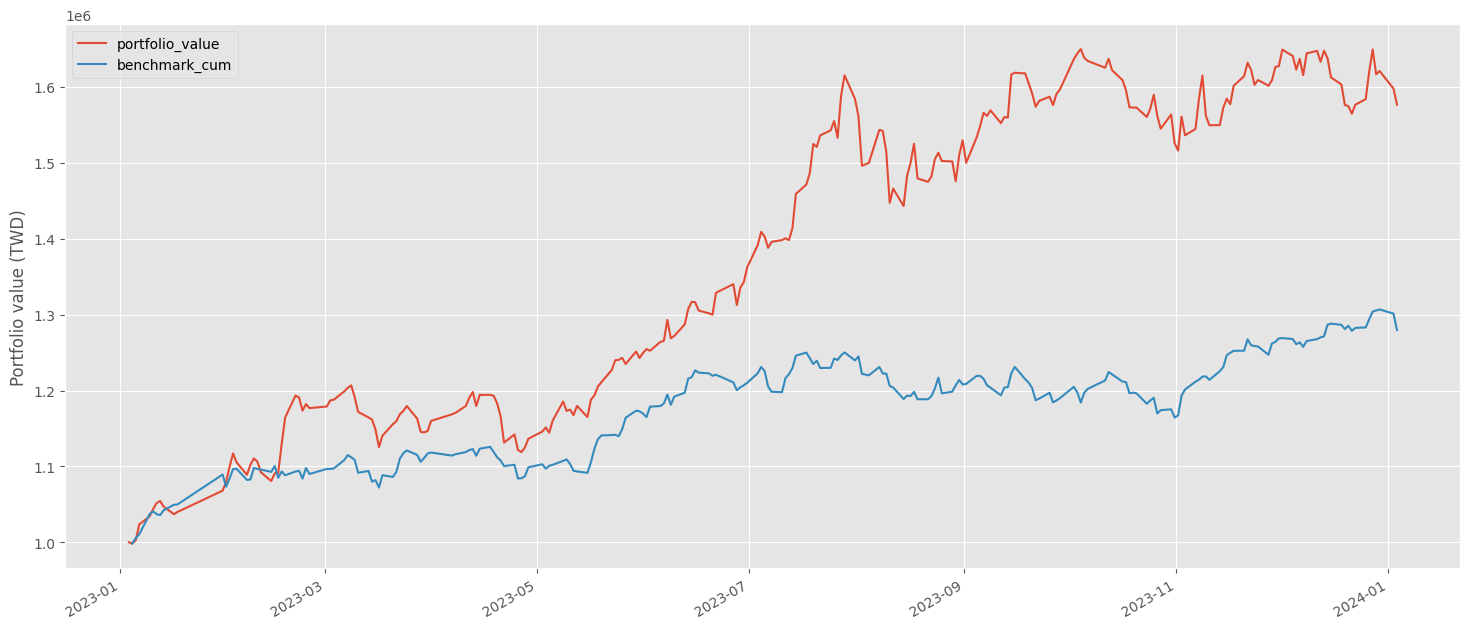

In [34]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp('20230101', tz = 'utc')
end_date = pd.Timestamp('20240103', tz = 'utc')  # 轉換成時間序列格式

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

### 不同滑價模型

In [50]:
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp('20230101', tz = 'utc')
end_date = pd.Timestamp('20240103', tz = 'utc')  # 轉換成時間序列格式

results = {}

for slip in ['set_slippage(slippage.NoSlippage())', 'set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.1, price_impact = 0.1))', 'set_slippage(slippage.FixedSlippage(spread = 10))', 'set_slippage(slippage.FixedBasisPointsSlippage(basis_points=200.0, volume_limit=0.1))']:

    def initialize(context):
        context.day = 0
        context.tickers = tickers
        eval(slip)
        set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
        set_benchmark(symbol('IR0001'))
        set_liquidity_risk_management_rule(['全額交割股票(Full-Cash Delivery Securities)', '漲停股票(Limit Up)', '跌停股票(Limit Down)', '開盤即鎖死(Limited Whole Day)'])

    def handle_data(context, data):

        #回測第一天買進
        if context.day == 0:
            for ticker in context.tickers:
                order_percent(symbol(ticker), 1 / len(tickers))

        
        elif get_datetime().date() == pd.Timestamp('20240102'):
            for coid in context.portfolio.positions:
                order_target_percent(coid, 0)


        context.day += 1  # 以免重複買進

    tmp = run_algorithm(
        start = start_date,
        end = end_date,
        initialize = initialize,
        handle_data = handle_data,
        #analyze = analyze,
        bundle = 'tquant',
        capital_base = capital_base,
    )

    results[slip] = tmp

[2024-05-14 03:50:34.846937]: INFO: earn_dividends: Equity(4 [3563]), cash_dividend amount: 8.0, pay_date: 2023-07-05, div_owed: 10136.0
[2024-05-14 03:50:34.867901]: INFO: earn_dividends: Equity(3 [3014]), cash_dividend amount: 6.0, pay_date: 2023-07-21, div_owed: 13476.0
[2024-05-14 03:50:34.876901]: INFO: earn_dividends: Equity(5 [4961]), cash_dividend amount: 8.5, pay_date: 2023-07-26, div_owed: 11517.5
[2024-05-14 03:50:34.967423]: INFO: earn_dividends: Equity(0 [1475]), cash_dividend amount: 0.5, pay_date: 2023-09-08, div_owed: 1302.0
[2024-05-14 03:50:34.981424]: INFO: earn_dividends: Equity(1 [2059]), cash_dividend amount: 20.0, pay_date: 2023-09-28, div_owed: 8700.0
[2024-05-14 03:50:34.982442]: INFO: earn_dividends: Equity(2 [2441]), cash_dividend amount: 3.6999999999999997, pay_date: 2023-09-27, div_owed: 12872.3
[2024-05-14 03:50:35.000423]: INFO: earn_dividends: Equity(5 [4961]), cash_dividend amount: 3.5, pay_date: 2023-09-18, div_owed: 4742.5
[2024-05-14 03:50:35.018430]

In [51]:
no_returns = results['set_slippage(slippage.NoSlippage())']['returns']
fixed_returns = results['set_slippage(slippage.FixedSlippage(spread = 10))']['returns']
volumeshare_returns = results['set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.1, price_impact = 0.1))']['returns']
fixedbasic_returns = results['set_slippage(slippage.FixedBasisPointsSlippage(basis_points=200.0, volume_limit=0.1))']['returns']

benchmark_rets = results['set_slippage(slippage.NoSlippage())']['benchmark_return']

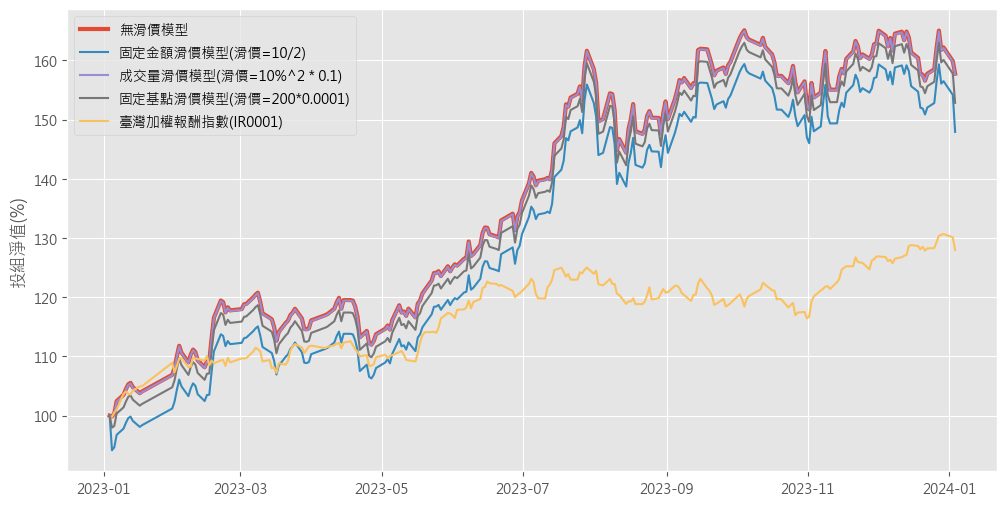

In [52]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(no_returns.add(1).cumprod()*100, label='無滑價模型', linewidth=3)
ax.plot(fixed_returns.add(1).cumprod()*100, label='固定金額滑價模型(滑價=10/2)')
ax.plot(volumeshare_returns.add(1).cumprod()*100, label='成交量滑價模型(滑價=10%^2 * 0.1)')
ax.plot(fixedbasic_returns.add(1).cumprod()*100, label='固定基點滑價模型(滑價=200*0.0001)')

ax.plot(benchmark_rets.add(1).cumprod()*100, label='臺灣加權報酬指數(IR0001)')

plt.ylabel('投組淨值(%)')
plt.legend()

In [38]:
positions, transactions, orders = get_transaction_detail(results['set_slippage(slippage.FixedBasisPointsSlippage(basis_points=200.0, volume_limit=0.1))'])

In [39]:
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results['set_slippage(slippage.FixedBasisPointsSlippage(basis_points=200.0, volume_limit=0.1))'])

transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2023-01-04 05:30:00+00:00,Equity(2 [2441]),Equity(2 [2441]),48.909,0e426204fd3d42acb5ab5b5feaa29e35,3479,None,2023-01-04 13:30:00+08:00,-170154.411
2023-01-04 05:30:00+00:00,Equity(0 [1475]),Equity(0 [1475]),65.382,6bf50156e36d4f74ac9983e59e656552,1600,None,2023-01-04 13:30:00+08:00,-104611.200
2023-01-04 05:30:00+00:00,Equity(4 [3563]),Equity(4 [3563]),133.620,d0a36478927e4a8e823c5689606e5068,1267,None,2023-01-04 13:30:00+08:00,-169296.540
2023-01-04 05:30:00+00:00,Equity(1 [2059]),Equity(1 [2059]),401.880,e59fb5c5057f4c9e8341200539aa6b41,435,None,2023-01-04 13:30:00+08:00,-174817.800
2023-01-04 05:30:00+00:00,Equity(3 [3014]),Equity(3 [3014]),75.786,52cf7c6f26ce412d8e9e890df81f4b07,2246,None,2023-01-04 13:30:00+08:00,-170215.356
2023-01-04 05:30:00+00:00,Equity(5 [4961]),Equity(5 [4961]),128.520,b72b12da2c674594a7e34c64f4324eef,1355,None,2023-01-04 13:30:00+08:00,-174144.600
2023-01-05 05:30:00+00:00,Equity(0 [1475]),Equity(0 [1475]),66.300,6bf50156e36d4f74ac9983e59e656552,1004,None,2023-01-05 13:30:00+08:00,-66565.200
2024-01-03 05:30:00+00:00,Equity(2 [2441]),Equity(2 [2441]),58.996,4bb08bd3089643abbed818b40cdd65a0,-3479,None,2024-01-03 13:30:00+08:00,205247.084
2024-01-03 05:30:00+00:00,Equity(4 [3563]),Equity(4 [3563]),204.330,265ea5589d814d62b1b19554640546a4,-1267,None,2024-01-03 13:30:00+08:00,258886.110
2024-01-03 05:30:00+00:00,Equity(1 [2059]),Equity(1 [2059]),854.560,33638a53a93044ad90e1de236f62ed6f,-435,None,2024-01-03 13:30:00+08:00,371733.600


### 不同手續費模型

In [40]:
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp('20230101', tz = 'utc')
end_date = pd.Timestamp('20240103', tz = 'utc')  # 轉換成時間序列格式

results = {}

for comm in ['set_commission(commission.NoCommission())', 'set_commission(commission.PerDollar(cost=0.001425))', 'set_commission(commission.PerTrade(cost=20))',
             'set_commission(commission.PerShare(cost=0.001425, min_trade_cost=20))', 'set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))']:

    def initialize(context):
        context.day = 0
        context.tickers = tickers
        eval(comm)
        set_slippage(slippage.NoSlippage())
        set_benchmark(symbol('IR0001'))
        set_liquidity_risk_management_rule(['全額交割股票(Full-Cash Delivery Securities)', '漲停股票(Limit Up)', '跌停股票(Limit Down)', '開盤即鎖死(Limited Whole Day)'])

    tmp = run_algorithm(
        start = start_date,
        end = end_date,
        initialize = initialize,
        handle_data = handle_data,
        #analyze = analyze,
        bundle = 'tquant',
        capital_base = capital_base,
    )

    results[comm] = tmp

In [41]:
no_returns = results['set_commission(commission.NoCommission())']['returns']
PerDollar_returns = results['set_commission(commission.PerDollar(cost=0.001425))']['returns']
PerTrade_returns = results['set_commission(commission.PerTrade(cost=20))']['returns']
PerShare_returns = results['set_commission(commission.PerShare(cost=0.001425, min_trade_cost=20))']['returns']
tw_returns = results['set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))']['returns']

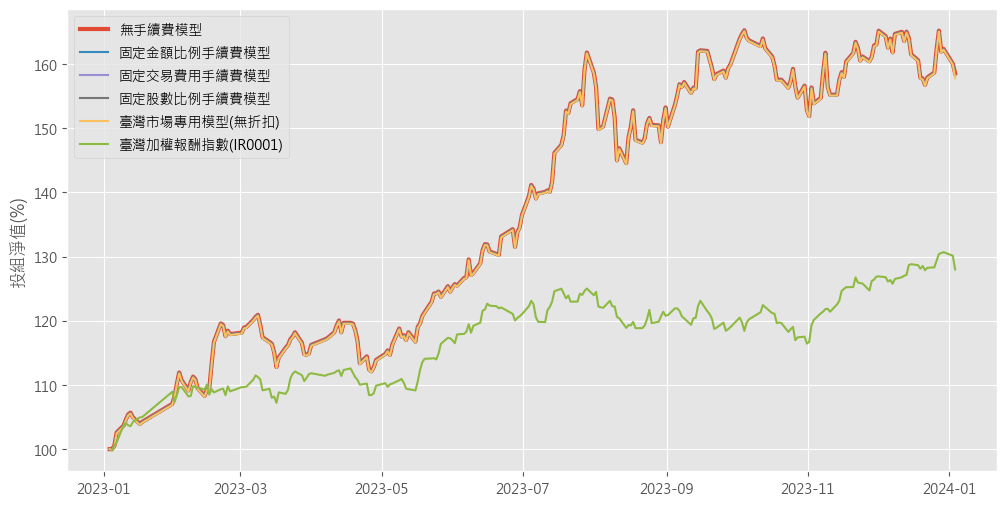

In [42]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(no_returns.add(1).cumprod()*100, label='無手續費模型', linewidth=3)
ax.plot(PerDollar_returns.add(1).cumprod()*100, label='固定金額比例手續費模型')
ax.plot(PerTrade_returns.add(1).cumprod()*100, label='固定交易費用手續費模型')
ax.plot(PerShare_returns.add(1).cumprod()*100, label='固定股數比例手續費模型')
ax.plot(tw_returns.add(1).cumprod()*100, label='臺灣市場專用模型(無折扣)')

ax.plot(benchmark_rets.add(1).cumprod()*100, label='臺灣加權報酬指數(IR0001)')

plt.ylabel('投組淨值(%)')
plt.legend()

In [43]:
positions, transactions, orders = get_transaction_detail(results['set_commission(commission.PerDollar(cost=0.001425))'])

orders

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2023-01-03 13:30:00+08:00,2,2441,7a3a0625c5d14fffa0b05d7c3f8d0396,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,3479,0,0.000000,None,None,False,False,Equity(2 [2441]),0
2023-01-03 13:30:00+08:00,0,1475,8fbcca9e056e437ebd5a425e81bdacd6,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,2604,0,0.000000,None,None,False,False,Equity(0 [1475]),0
2023-01-03 13:30:00+08:00,4,3563,418c1dda0895444d88c7559d3bb9391a,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,1267,0,0.000000,None,None,False,False,Equity(4 [3563]),0
2023-01-03 13:30:00+08:00,1,2059,5aadf3c660ba4ca8b90db035daf2285c,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,435,0,0.000000,None,None,False,False,Equity(1 [2059]),0
2023-01-03 13:30:00+08:00,3,3014,2296d55c7f7841fa9c000d0db6e66e36,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,2246,0,0.000000,None,None,False,False,Equity(3 [3014]),0
2023-01-03 13:30:00+08:00,5,4961,d037d131a16c44a89bfb7e5c8a100cd5,2023-01-03 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,1355,0,0.000000,None,None,False,False,Equity(5 [4961]),0
2023-01-04 13:30:00+08:00,2,2441,7a3a0625c5d14fffa0b05d7c3f8d0396,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,3479,3479,237.715721,None,None,False,False,Equity(2 [2441]),1
2023-01-04 13:30:00+08:00,0,1475,8fbcca9e056e437ebd5a425e81bdacd6,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,2604,2604,237.855870,None,None,False,False,Equity(0 [1475]),1
2023-01-04 13:30:00+08:00,4,3563,418c1dda0895444d88c7559d3bb9391a,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,1267,1267,236.517225,None,None,False,False,Equity(4 [3563]),1
2023-01-04 13:30:00+08:00,1,2059,5aadf3c660ba4ca8b90db035daf2285c,2023-01-04 13:30:00+08:00,None,2023-01-03 13:30:00+08:00,435,435,244.230750,None,None,False,False,Equity(1 [2059]),1


### 交易限制

交易限制功能可以確保演算法如您所預期的的方式執行，並有助於避免預期外交易所帶來的不良後果。

交易限制系列函數通常在initialize階段使用，並且可以一次加入多個交易限制。

因為交易限制函數皆是 zipline api 方法，需先from zipline.api import <欲使用的方法> 或 from zipline.api import *。

1. set_do_not_order_list(restricted_list, on_error='fail')
    - restricted_list (container[Asset], SecurityList)：預先限制不能交易的股票清單。
    - on_error有兩種選項：'fail' 和 'log'。前者直接中斷程式並顯示錯誤訊息，後者會照樣執行但記錄錯誤。預設為'fail'。
--------------------------------------
2. set_long_only(on_error='fail')
    - on_error有兩種選項：'fail' 和 'log'。前者直接中斷程式並顯示錯誤訊息，後者會照樣執行但記錄錯誤。預設為'fail'。
--------------------------------------
3. set_max_leverage(max_leverage)
    - 投資組合的最高槓桿，必須 > 0。這邊的槓桿指的是gross leverage。**無法選擇以'log'方式呈現。**
--------------------------------------
4. set_max_order_count(max_count, on_error='fail')
    - max_count (int)：一天內最多的下單數。
    - on_error：'fail' 和 'log'。前者直接中斷程式並顯示錯誤訊息，後者會照樣執行但記錄錯誤。預設為'fail'。

--------------------------------------
5. set_max_order_size(asset=None, max_shares=None, max_notional=None, on_error='fail')
    - Asset：（zipline.assets.Asset，例如：Equity(0 [1101])，透過symbol("1101")可將 symbol 轉成Asset物件）
    - max_shares (int, optional)：最大單次下單股數。
    - max_notional (float, optional)：最大單次下單金額。
    - on_error：'fail' 和 'log'。前者直接中斷程式並顯示錯誤訊息，後者會照樣執行但記錄錯誤。預設為'fail'。
    
--------------------------------------

6. set_max_position_size(asset=None, max_shares=None, max_notional=None, on_error='fail')

    - asset：必須是Asset物件（zipline.assets.Asset，例如：Equity(0 [1101])）
    - max_shares (int, optional)－最大持股股數。
    - max_notional (float, optional)－最大持股市值。
    - on_error有兩種選項：'fail' 和 'log'。前者直接中斷程式並顯示錯誤訊息，後者會照樣執行但記錄錯誤。預設為'fail'。

[2024-05-14 03:47:46.515966]: ERROR: handle_violation: Order for 2604 shares of Equity(0 [1475]) at 2023-01-03 05:30:00+00:00 violates trading constraint RestrictedListOrder({})
[2024-05-14 03:47:46.866722]: INFO: earn_dividends: Equity(4 [3563]), cash_dividend amount: 8.0, pay_date: 2023-07-05, div_owed: 10136.0
[2024-05-14 03:47:46.887196]: INFO: earn_dividends: Equity(3 [3014]), cash_dividend amount: 6.0, pay_date: 2023-07-21, div_owed: 13476.0
[2024-05-14 03:47:46.895200]: INFO: earn_dividends: Equity(5 [4961]), cash_dividend amount: 8.5, pay_date: 2023-07-26, div_owed: 11517.5
[2024-05-14 03:47:46.976742]: INFO: earn_dividends: Equity(0 [1475]), cash_dividend amount: 0.5, pay_date: 2023-09-08, div_owed: 1302.0
[2024-05-14 03:47:46.990742]: INFO: earn_dividends: Equity(1 [2059]), cash_dividend amount: 20.0, pay_date: 2023-09-28, div_owed: 8700.0
[2024-05-14 03:47:46.991742]: INFO: earn_dividends: Equity(2 [2441]), cash_dividend amount: 3.6999999999999997, pay_date: 2023-09-27, div_

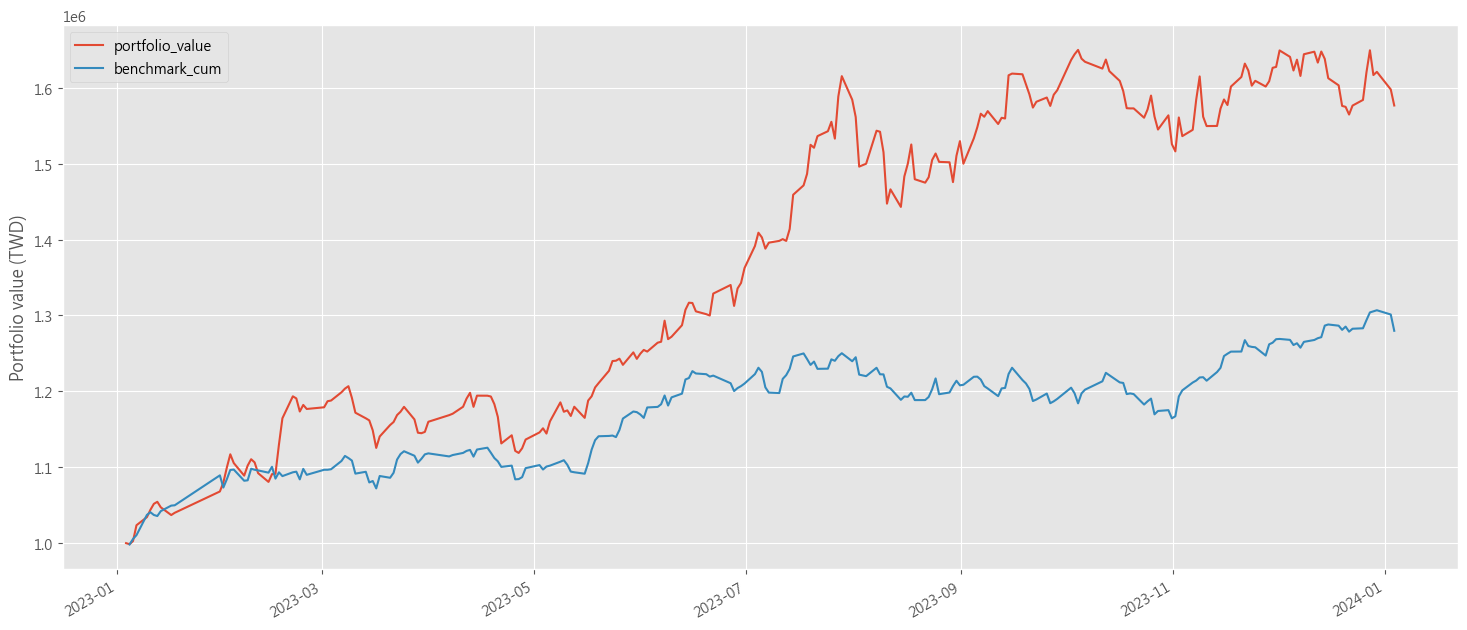

In [44]:
from logbook import Logger, StderrHandler, INFO
# 設定log顯示方式
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.1, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    set_liquidity_risk_management_rule(['全額交割股票(Full-Cash Delivery Securities)', '漲停股票(Limit Up)', '跌停股票(Limit Down)', '開盤即鎖死(Limited Whole Day)'])

    set_do_not_order_list(restricted_list = [symbol('1475')], on_error='log')

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

### 不同order下單模式

In [45]:
def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.1, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    set_liquidity_risk_management_rule(['全額交割股票(Full-Cash Delivery Securities)', '漲停股票(Limit Up)', '跌停股票(Limit Down)', '開盤即鎖死(Limited Whole Day)'])

In [46]:
def handle_data(context, data):

    if context.day % 21 == 0:
        order_value(symbol('4961'), 1e5)

    context.day += 1  # 以免重複買進

[2024-05-14 03:47:47.843410]: INFO: earn_dividends: Equity(5 [4961]), cash_dividend amount: 8.5, pay_date: 2023-07-26, div_owed: 33770.5
[2024-05-14 03:47:47.937939]: INFO: earn_dividends: Equity(5 [4961]), cash_dividend amount: 3.5, pay_date: 2023-09-18, div_owed: 19075.0
[2024-05-14 03:47:47.953939]: INFO: handle_split: after split: asset: Equity(5 [4961]), amount: 3623, cost_basis: 220.68, last_sale_price: 156.5
[2024-05-14 03:47:47.953939]: INFO: handle_split: returning cash: 134.08
[2024-05-14 03:47:48.097996]: INFO: handle_simulation_end: Simulated 241 trading days
first open: 2023-01-03 01:01:00+00:00
last close: 2024-01-03 05:30:00+00:00


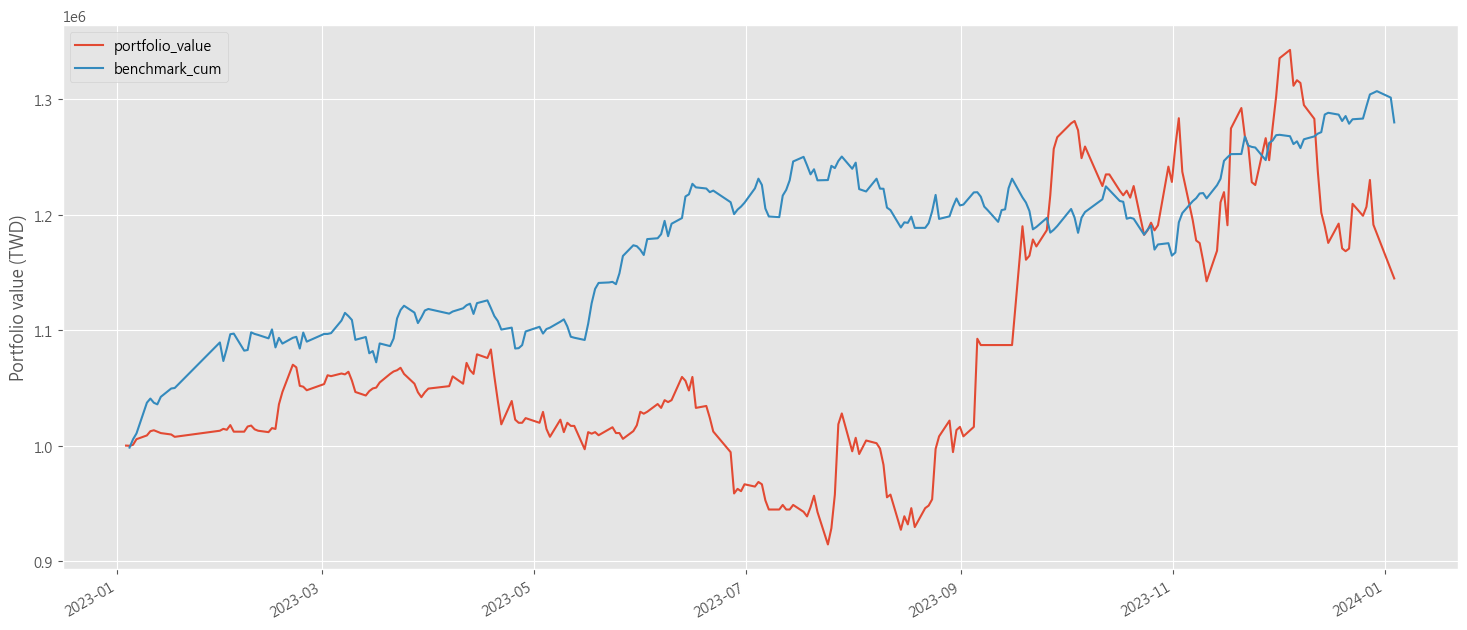

In [47]:
results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

In [48]:
positions, transactions, orders = get_transaction_detail(results)

transactions.assign(txn=lambda x: x['amount'] * x['price'])

,sid,symbol,amount,dt,price,order_id,asset,commission,txn
2023-01-04 13:30:00+08:00,5,4961,813,2023-01-04 13:30:00+08:00,126.000000,403f64d6ec87497d92f8265fd1f980b1,Equity(5 [4961]),None,102438.000084
2023-02-14 13:30:00+08:00,5,4961,711,2023-02-14 13:30:00+08:00,145.000001,75a1af09daba41c4aa18b08fd4e08eb6,Equity(5 [4961]),None,103095.000473
2023-03-17 13:30:00+08:00,5,4961,595,2023-03-17 13:30:00+08:00,171.000000,23f42312a8174cf7abe9091adde1c034,Equity(5 [4961]),None,101745.000071
2023-04-20 13:30:00+08:00,5,4961,576,2023-04-20 13:30:00+08:00,163.500000,78efb117e2f849d5b3460acbb4d82a9c,Equity(5 [4961]),None,94176.000033
2023-05-22 13:30:00+08:00,5,4961,655,2023-05-22 13:30:00+08:00,154.500003,34fdd1dea3074851a8cf66edbea7b105,Equity(5 [4961]),None,101197.502076
2023-06-20 13:30:00+08:00,5,4961,623,2023-06-20 13:30:00+08:00,157.500002,1b71d574296f494687e958ed97fcd77e,Equity(5 [4961]),None,98122.501535
2023-07-21 13:30:00+08:00,5,4961,711,2023-07-21 13:30:00+08:00,137.000003,ab7c67e6908f4238ab6f7c11bd950fe4,Equity(5 [4961]),None,97407.002233
2023-08-22 13:30:00+08:00,5,4961,766,2023-08-22 13:30:00+08:00,131.000007,ba8e1772b3f84103b343ae73e7793241,Equity(5 [4961]),None,100346.005486
2023-09-20 13:30:00+08:00,5,4961,399,2023-09-20 13:30:00+08:00,251.500000,5095053d677348d6a3a6086f73571d2e,Equity(5 [4961]),None,100348.500023
2023-10-24 13:30:00+08:00,5,4961,390,2023-10-24 13:30:00+08:00,257.000004,a968e90ad028443da6aca2a36072e48e,Equity(5 [4961]),None,100230.001634
